In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
from sklearn import preprocessing 




# Cargar los archivos CSV
fe_cp = pd.read_csv('/kaggle/input/business-payment/extract - fees - data analyst - .csv')
cr_cp = pd.read_csv('/kaggle/input/business-payment/extract - cash request - data analyst.csv')
#cr_cp.info()
#fe_cp.info()

data_shape = cr_cp.shape
print(f"\nForma del DataFrame Cash Request (filas, columnas): {data_shape}")

column_names = cr_cp.columns
print(f"\nNombres de Columnas: {column_names}")
 
data_types = cr_cp.dtypes
print(f"\nTipos de datos de cada columna:\n{data_types}")

data_shape = fe_cp.shape
print(f"\nForma del DataFrame Fees (filas, columnas): {data_shape}")

column_names = fe_cp.columns
print(f"\nNombres de Columnas: {column_names}")
 
data_types = fe_cp.dtypes
print(f"\nTipos de datos de cada columna:\n{data_types}")

/kaggle/input/business-payment/extract - fees - data analyst - .csv
/kaggle/input/business-payment/extract - cash request - data analyst.csv

Forma del DataFrame Cash Request (filas, columnas): (23970, 16)

Nombres de Columnas: Index(['id', 'amount', 'status', 'created_at', 'updated_at', 'user_id',
       'moderated_at', 'deleted_account_id', 'reimbursement_date',
       'cash_request_received_date', 'money_back_date', 'transfer_type',
       'send_at', 'recovery_status', 'reco_creation', 'reco_last_update'],
      dtype='object')

Tipos de datos de cada columna:
id                              int64
amount                        float64
status                         object
created_at                     object
updated_at                     object
user_id                       float64
moderated_at                   object
deleted_account_id            float64
reimbursement_date             object
cash_request_received_date     object
money_back_date                object
transfer_typ

**Fees Dataset:**

**Status:**
accepted: 14,841 registros.
cancelled: 4,938 registros.
rejected: 1,194 registros.
confirmed: 88 registros.

**Transfer Type:**
instant_payment: 11,099 registros.
postpone: 7,766 registros.
incident: 2,196 registros.

**Recovery Status:**
rejected_direct_debit: 1,599 registros.
month_delay_on_payment: 597 registros.

**Cash Request Dataset:**

**Status:**
money_back: 16,397 registros.
rejected: 6,568 registros.
direct_debit_rejected: 831 registros.
active: 59 registros.
transaction_declined: 48 registros.
direct_debit_sent: 34 registros.
canceled: 33 registros.

**Transfer Type:**
instant: 13,882 registros.
regular: 10,088 registros.

**Recovery Status:**
completed: 2,468 registros.
pending: 845 registros.
pending_direct_debit: 16 registros.
cancelled: 1 registro.

**LIMPIEZA DE DATOS**

In [3]:
df_fe = pd.read_csv('/kaggle/input/business-payment/extract - fees - data analyst - .csv')
df_cr = pd.read_csv('/kaggle/input/business-payment/extract - cash request - data analyst.csv')
#df.info()

# DEJAMOS FUERA los registros donde cash_request_id no tiene id_cr
filtros = df_fe['cash_request_id'].isin(df_cr['id']) 


# Crear un nuevo DataFrame con los registros filtrados
df_faltantes = df_fe[filtros]

# Mostrar los resultados
print("Registros donde cash_request_id tiene id_cr asociado:")
display(df_faltantes)

Registros donde cash_request_id tiene id_cr asociado:


,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.42315+00,2020-10-13 14:25:09.396112+00,2020-12-17 14:50:07.47011+00,NaN,NaN,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00,2020-10-13 14:25:15.537063+00,2020-12-08 17:13:10.45908+00,NaN,NaN,after
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00,2020-10-23 10:10:58.352994+00,2020-11-04 19:34:37.43291+00,NaN,NaN,after
3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00,2020-10-31 15:46:53.643982+00,2020-11-19 05:09:22.500223+00,NaN,NaN,after
4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00,2020-10-13 14:25:03.267983+00,2020-11-02 14:45:20.355598+00,NaN,NaN,after
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21056,12372,20262.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 20262,2020-10-10 06:42:22.822743+00,2020-10-13 14:25:04.18049+00,2020-11-17 05:14:00.080854+00,NaN,NaN,after
21057,20768,26764.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 26764,2020-10-31 15:24:18.680694+00,2020-10-31 15:24:18.680715+00,2020-12-16 07:10:54.697639+00,NaN,NaN,after
21058,18779,25331.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 25331,2020-10-27 17:28:51.749177+00,2020-10-27 17:28:51.7492+00,2020-11-18 04:35:42.915511+00,NaN,NaN,after
21059,16542,23628.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 23628,2020-10-23 16:27:52.047457+00,2020-10-23 16:27:52.047486+00,2020-12-18 05:18:01.465317+00,NaN,NaN,after


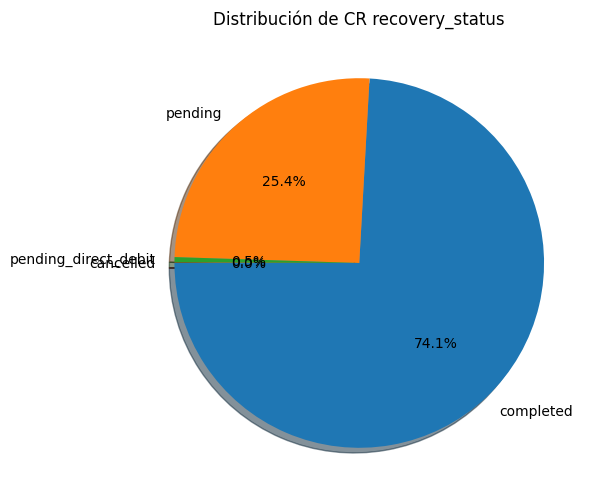

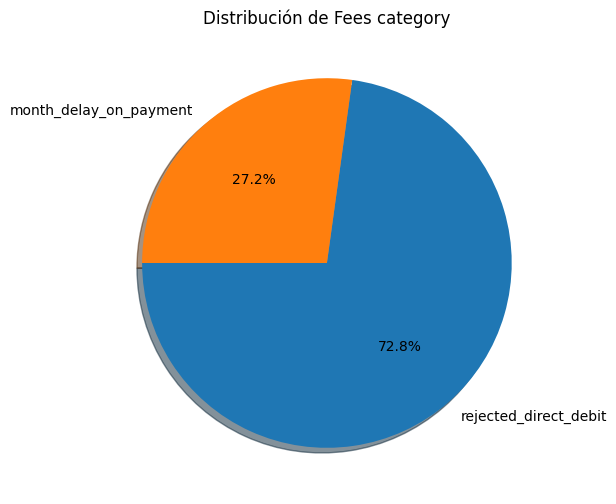

In [4]:
import matplotlib.pyplot as plt

cash_request_data = pd.read_csv('/kaggle/input/business-payment/extract - cash request - data analyst.csv')
fees_data = pd.read_csv('/kaggle/input/business-payment/extract - fees - data analyst - .csv')
# Columnas correctas según tu dataset: 'status', 'transfer_type', 'recovery_status' en cash_request_data y 'status', 'type', 'category' en fees_data.

import matplotlib.pyplot as plt

# Gráfico de recovery_status en cash_request_data
recovery_counts = cash_request_data['recovery_status'].value_counts().nlargest(4)
plt.figure(figsize=(8, 6))
recovery_counts.plot.pie(autopct='%1.1f%%', shadow=True, startangle=180)
plt.title("Distribución de CR recovery_status")
plt.ylabel("")
plt.show()

# Gráfico de category en fees_data
category_counts = fees_data['category'].value_counts()
plt.figure(figsize=(8, 6))
category_counts.plot.pie(autopct='%1.1f%%', shadow=True, startangle=180)
plt.title("Distribución de Fees category")
plt.ylabel("")
plt.show()

<ipython-input-5-09647cac91f8>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_request_data['Mes_created_at_d'] = pd.to_datetime(cash_request_data['created_at']).dt.to_period('D').astype(str)
<ipython-input-5-09647cac91f8>:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_request_data['Mes_created_at_w'] = pd.to_datetime(cash_request_data['created_at']).dt.to_period('W-WED').astype(str)
<ipython-input-5-09647cac91f8>:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_request_data['Mes_created_at_m'] = pd.to_datetime(cash_request_data['created_at']).dt.to_period('M').astype(str)


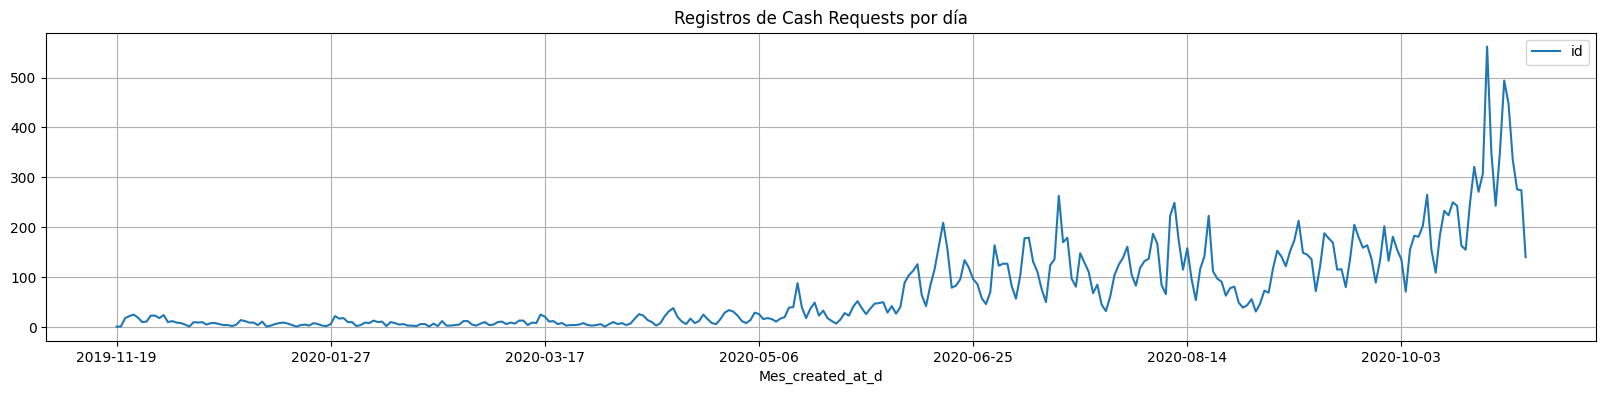

In [5]:
# Crear nuevas columnas con periodos de tiempo
cash_request_data['Mes_created_at_d'] = pd.to_datetime(cash_request_data['created_at']).dt.to_period('D').astype(str)
cash_request_data['Mes_created_at_w'] = pd.to_datetime(cash_request_data['created_at']).dt.to_period('W-WED').astype(str)
cash_request_data['Mes_created_at_m'] = pd.to_datetime(cash_request_data['created_at']).dt.to_period('M').astype(str)

# Campos a contar
fields = ['id']  # Usando 'id' como identificador en cash_request_data

# Gráfico de líneas por días
fig, ax = plt.subplots(figsize=(20, 4))
plt.title('Registros de Cash Requests por día')
ratio_bag = cash_request_data.groupby('Mes_created_at_d')[fields].count()
ratio_bag.plot(kind='line', ax=ax)
plt.grid()
plt.show()

#Este error significa que al convertir la columna created_at a un formato de periodo (to_period), se está perdiendo la información de la zona horaria (timezone) si tus datos incluyen información de tiempo en formato UTC o con un offset horario.

In [6]:
import pandas as pd

# Asegurar que las fechas no tengan zona horaria, manejando errores
cash_request_data['created_at'] = pd.to_datetime(cash_request_data['created_at'], errors='coerce').dt.tz_localize(None)
cash_request_data['cash_request_received_date'] = pd.to_datetime(cash_request_data['cash_request_received_date'], errors='coerce').dt.tz_localize(None)

cash_request_data['to_receive_bank'] = (cash_request_data['cash_request_received_date'] - cash_request_data['created_at']).dt.days
print("Tiempo promedio en dar el dinero al cliente:", cash_request_data['to_receive_bank'].mean())

fees_data['created_at'] = pd.to_datetime(fees_data['created_at'], errors='coerce').dt.tz_localize(None)
fees_data['paid_at'] = pd.to_datetime(fees_data['paid_at'], errors='coerce').dt.tz_localize(None)

fees_data['to_fee_paid_delay'] = (fees_data['paid_at'] - fees_data['created_at']).dt.days
fees_delay = fees_data[(fees_data['to_fee_paid_delay'].notna()) & (fees_data['status'] == 'accepted')]
print("Tiempo promedio en cobrar los fees:", fees_delay['to_fee_paid_delay'].mean())



Tiempo promedio en dar el dinero al cliente: 1.6738289643317577
Tiempo promedio en cobrar los fees: 24.1018345448252


**Tiempo promedio en dar el dinero al cliente: 1.6738289643317577**

**Tiempo promedio en cobrar los fees: 24.1018345448252**

In [7]:
df = cash_request_data

# Mostrar registros con valores nulos en cash_request_received_date
display(df[(df['cash_request_received_date'].isna()) & (df['status'] == 'money_back')])

# Normalizar llenando cash_request_received_date con reimbursement_date si falta
df['cash_request_received_date'] = df.apply(
    lambda row: row['reimbursement_date'] if (pd.isna(row['cash_request_received_date']) and row['status'] == 'money_back') else row['cash_request_received_date'], axis=1
)

# Mostrar registros faltantes después de normalizar
display(df[(df['cash_request_received_date'].isna()) & (df['status'] == 'money_back')])


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,Mes_created_at_d,Mes_created_at_w,Mes_created_at_m,to_receive_bank
48,23534,25.0,money_back,2020-10-23 15:20:26.163927,2020-12-18 13:08:29.099365+00,21465.0,NaN,NaN,2020-11-10 23:51:00+00,NaT,2020-11-06 07:16:21.845479+00,instant,2020-10-23 15:21:26.878525+00,NaN,NaN,NaN,2020-10-23,2020-10-22/2020-10-28,2020-10,NaN
173,2297,100.0,money_back,2020-05-29 11:55:37.223818,2020-06-08 16:32:23.469545+00,10497.0,2020-06-06 08:26:20.437596+00,NaN,2020-06-28 11:56:29.64+00,NaT,2020-06-08 16:32:23.469253+00,regular,NaN,NaN,NaN,NaN,2020-05-29,2020-05-28/2020-06-03,2020-05,NaN
1025,625,100.0,money_back,2020-02-06 18:54:50.889581,2020-04-06 13:11:16.917436+00,3057.0,2020-02-07 13:31:30.685431+00,NaN,2020-03-12 18:54:50.882966+00,NaT,2020-04-06 13:11:16.917213+00,regular,NaN,NaN,NaN,NaN,2020-02-06,2020-02-06/2020-02-12,2020-02,NaN
1163,2096,10.0,money_back,2020-05-21 11:26:26.659202,2020-05-22 11:35:38.106826+00,NaN,2020-05-21 11:26:50.655268+00,1310.0,2020-06-07 22:00:00+00,NaT,2020-05-22 11:35:38.106598+00,regular,NaN,NaN,NaN,NaN,2020-05-21,2020-05-21/2020-05-27,2020-05,NaN
1303,2121,100.0,money_back,2020-05-22 11:54:03.891644,2020-06-11 21:56:44.330972+00,9436.0,2020-05-22 11:59:38.735822+00,NaN,2020-06-05 11:58:50.276+00,NaT,2020-06-11 21:56:44.330735+00,regular,NaN,NaN,NaN,NaN,2020-05-22,2020-05-21/2020-05-27,2020-05,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23922,23989,25.0,money_back,2020-10-24 10:22:05.934286,2020-12-18 13:14:25.891447+00,NaN,NaN,29610.0,2020-11-03 10:22:40.194197+00,NaT,2020-11-16 02:57:54.235926+00,instant,2020-10-24 10:22:40.194197+00,completed,2020-11-13 22:40:42.99552+00,2020-11-16 02:57:54.252045+00,2020-10-24,2020-10-22/2020-10-28,2020-10,NaN
23928,19329,100.0,money_back,2020-10-05 19:38:30.924473,2021-02-02 20:01:45.37099+00,20237.0,2020-10-06 08:07:25.588896+00,NaN,2021-02-02 11:00:00+00,NaT,2021-02-02 20:01:45.338251+00,instant,2020-10-12 19:38:30.878498+00,NaN,NaN,NaN,2020-10-05,2020-10-01/2020-10-07,2020-10,NaN
23938,21982,50.0,money_back,2020-10-18 16:23:59.844069,2021-02-04 19:31:16.45039+00,79003.0,NaN,NaN,2021-02-04 11:00:00+00,NaT,2021-02-04 19:31:16.413197+00,instant,2020-10-18 16:24:21.311186+00,NaN,NaN,NaN,2020-10-18,2020-10-15/2020-10-21,2020-10,NaN
23945,24501,100.0,money_back,2020-10-26 01:08:36.924732,2021-01-29 19:57:16.394292+00,48169.0,NaN,NaN,2021-01-28 23:00:00+00,NaT,2021-01-29 19:57:16.350745+00,instant,2020-10-26 01:09:05.631694+00,NaN,NaN,NaN,2020-10-26,2020-10-22/2020-10-28,2020-10,NaN


,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,Mes_created_at_d,Mes_created_at_w,Mes_created_at_m,to_receive_bank


**MERGE Y LIMPIEZA**

In [8]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = None

# Cargar datasets
cash_request_data = pd.read_csv('/kaggle/input/business-payment/extract - cash request - data analyst.csv')
fees_data = pd.read_csv('/kaggle/input/business-payment/extract - fees - data analyst - .csv')

# Convertir fechas a datetime
cash_request_data['send_at'] = pd.to_datetime(cash_request_data['send_at'], errors='coerce')
cash_request_data['cash_request_received_date'] = pd.to_datetime(cash_request_data['cash_request_received_date'], errors='coerce')
cash_request_data['created_at'] = pd.to_datetime(cash_request_data['created_at'], errors='coerce')
fees_data['created_at'] = pd.to_datetime(fees_data['created_at'], errors='coerce')

# Crear columna de periodo diario
cash_request_data['Mes_created_at_d'] = cash_request_data['created_at'].dt.to_period('D').astype(str)

# Normalizar fechas faltantes en cash_request_data
cash_request_data['cash_request_received_date'] = cash_request_data.apply(
    lambda row: row['send_at'] + pd.DateOffset(days=3)
    if pd.isna(row['cash_request_received_date']) and row['status'] == 'money_back'
    else row['cash_request_received_date'], axis=1
)

# Unir cash_request_data y fees_data usando cash_request_id
merged_data = pd.merge(cash_request_data, fees_data, left_on='id', right_on='cash_request_id', how='inner')

# Mostrar las columnas del dataset unido
display(merged_data.columns)

# Interpolar valores de amount y total_amount por día en merged_data
merged_data['Mes_created_at_d'] = merged_data['created_at_x'].dt.to_period('D').astype(str)
ratio_merged = merged_data.groupby('Mes_created_at_d')[['amount', 'total_amount']].mean().dropna()
display(ratio_merged)

display(merged_data.head())



<ipython-input-8-b49f8e179dcc>:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_request_data['Mes_created_at_d'] = cash_request_data['created_at'].dt.to_period('D').astype(str)


Index(['id_x', 'amount', 'status_x', 'created_at_x', 'updated_at_x', 'user_id',
       'moderated_at', 'deleted_account_id', 'reimbursement_date',
       'cash_request_received_date', 'money_back_date', 'transfer_type',
       'send_at', 'recovery_status', 'reco_creation', 'reco_last_update',
       'Mes_created_at_d', 'id_y', 'cash_request_id', 'type', 'status_y',
       'category', 'total_amount', 'reason', 'created_at_y', 'updated_at_y',
       'paid_at', 'from_date', 'to_date', 'charge_moment'],
      dtype='object')

<ipython-input-8-b49f8e179dcc>:33: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  merged_data['Mes_created_at_d'] = merged_data['created_at_x'].dt.to_period('D').astype(str)


,amount,total_amount
Mes_created_at_d,,
2020-04-29,100.000000,5.0
2020-05-01,100.000000,5.0
2020-05-05,116.666667,5.0
2020-05-06,100.000000,5.0
2020-05-08,100.000000,5.0
...,...,...
2020-10-28,53.669623,5.0
2020-10-29,59.053892,5.0
2020-10-30,69.354167,5.0


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,id_x,amount,status_x,created_at_x,updated_at_x,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,Mes_created_at_d,id_y,cash_request_id,type,status_y,category,total_amount,reason,created_at_y,updated_at_y,paid_at,from_date,to_date,charge_moment
0,23534,25.0,money_back,2020-10-23 15:20:26.163927+00:00,2020-12-18 13:08:29.099365+00,21465.0,NaN,NaN,2020-11-10 23:51:00+00,2020-10-26 15:21:26.878525+00:00,2020-11-06 07:16:21.845479+00,instant,2020-10-23 15:21:26.878525+00:00,NaN,NaN,NaN,2020-10-23,16460,23534.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23534,2020-10-23 15:21:35.895711+00:00,2020-10-23 15:21:35.89574+00,2020-11-06 07:16:22.014422+00,NaN,NaN,after
1,2203,100.0,money_back,2020-05-27 02:26:27.615190+00:00,2020-06-09 11:25:51.72636+00,2109.0,2020-05-27 10:02:13.094467+00,NaN,2020-07-15 02:26:27+00,2020-05-29 00:00:00,2020-07-15 22:00:00+00,regular,NaT,NaN,NaN,NaN,2020-05-27,100,2203.0,postpone,accepted,NaN,5.0,Postpone Cash Request 2203,2020-06-09 11:25:52.449808+00:00,2020-10-13 14:25:00.867548+00,NaN,2020-06-15 02:26:27+00,2020-07-15 02:26:27+00,before
2,6098,100.0,active,2020-07-01 09:30:03.145410+00:00,2020-08-11 22:27:58.240406+00,23328.0,2020-07-01 16:44:53.070844+00,NaN,2020-08-03 22:00:00+00,2020-07-03 00:00:00,NaN,regular,NaT,pending,2020-08-11 22:27:55.367849+00,2020-08-11 22:27:58.255621+00,2020-07-01,3733,6098.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 6098,2020-08-13 10:58:39.634220+00:00,2020-10-13 14:25:16.660127+00,NaN,2020-08-03 22:00:00+00,2020-09-03 10:58:32.274+00,after
3,6098,100.0,active,2020-07-01 09:30:03.145410+00:00,2020-08-11 22:27:58.240406+00,23328.0,2020-07-01 16:44:53.070844+00,NaN,2020-08-03 22:00:00+00,2020-07-03 00:00:00,NaN,regular,NaT,pending,2020-08-11 22:27:55.367849+00,2020-08-11 22:27:58.255621+00,2020-07-01,3734,6098.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 6098,2020-08-13 10:58:52.603153+00:00,2020-10-13 14:25:16.661371+00,NaN,2020-08-03 22:00:00+00,2020-09-03 10:58:32.274+00,after
4,6098,100.0,active,2020-07-01 09:30:03.145410+00:00,2020-08-11 22:27:58.240406+00,23328.0,2020-07-01 16:44:53.070844+00,NaN,2020-08-03 22:00:00+00,2020-07-03 00:00:00,NaN,regular,NaT,pending,2020-08-11 22:27:55.367849+00,2020-08-11 22:27:58.255621+00,2020-07-01,3735,6098.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 6098,2020-08-13 11:00:39.879521+00:00,2020-10-13 14:25:16.662449+00,NaN,2020-08-03 22:00:00+00,2020-09-01 11:00:34.027+00,after


#Tras unir los datasets, la columna id ha sido renombrada automáticamente como:

**id_x (proveniente de cash_request_data).**


**id_y (proveniente de fees_data).**

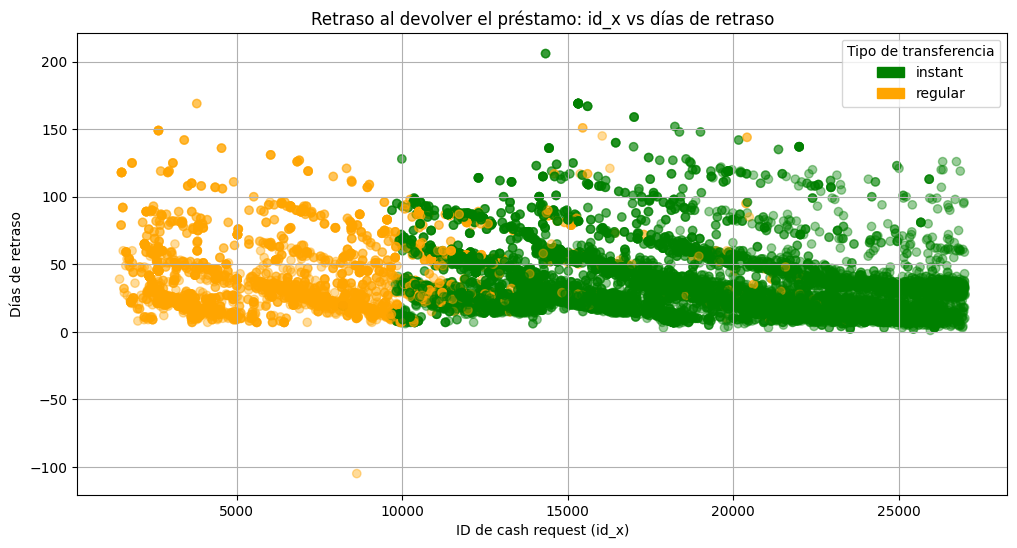

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Asegurar que las fechas sean datetime
merged_data['reimbursement_date'] = pd.to_datetime(merged_data['reimbursement_date'], errors='coerce')
merged_data['created_at_x'] = pd.to_datetime(merged_data['created_at_x'], errors='coerce')

classification_colors = {'instant': 'green', 'regular': 'orange'}

# Eliminar registros sin fecha de reembolso
merged_data = merged_data.dropna(subset=['reimbursement_date'])

x_values = merged_data['id_x']
y_values = (merged_data['reimbursement_date'] - merged_data['created_at_x']).dt.days
c_values = list(merged_data['transfer_type'].map(classification_colors))

fig, ax = plt.subplots(figsize=(12,6))
plt.scatter(x=x_values, y=y_values, c=c_values, alpha=0.4)
plt.title('Retraso al devolver el préstamo: id_x vs días de retraso')
plt.xlabel('ID de cash request (id_x)')
plt.ylabel('Días de retraso')

legend_patches = [mpatches.Patch(color=color, label=type) for type, color in classification_colors.items()]
plt.legend(handles=legend_patches, loc='best', title='Tipo de transferencia')
plt.grid()
plt.show()

#retraso para cada solicitud


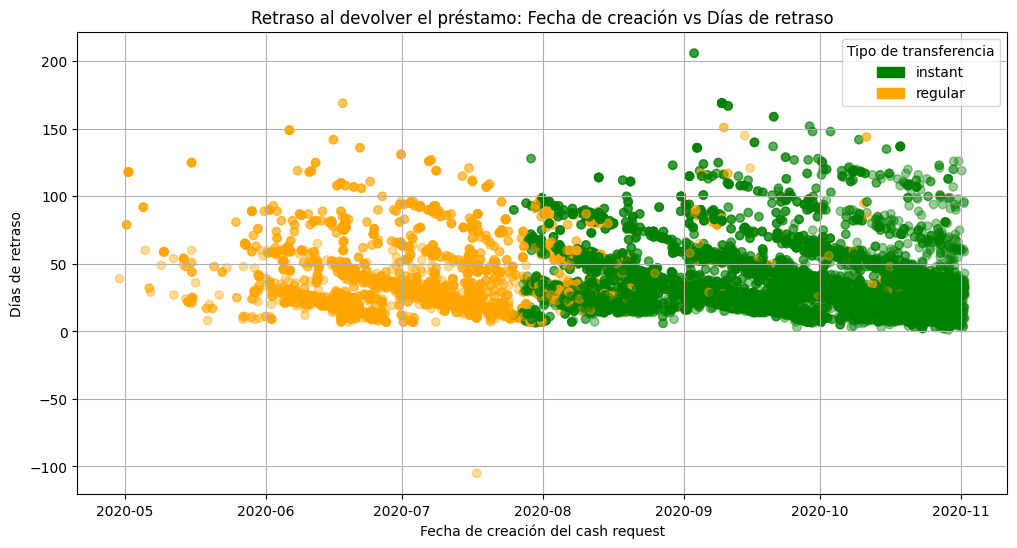

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Asegurar que las fechas sean datetime
merged_data['reimbursement_date'] = pd.to_datetime(merged_data['reimbursement_date'], errors='coerce')
merged_data['created_at_x'] = pd.to_datetime(merged_data['created_at_x'], errors='coerce')

classification_colors = {'instant': 'green', 'regular': 'orange'}

# Eliminar registros sin fecha de reembolso
merged_data = merged_data.dropna(subset=['reimbursement_date'])

# Valores para el gráfico
x_values = merged_data['created_at_x']
y_values = (merged_data['reimbursement_date'] - merged_data['created_at_x']).dt.days
c_values = list(merged_data['transfer_type'].map(classification_colors))

# Crear el gráfico
fig, ax = plt.subplots(figsize=(12,6))
plt.scatter(x=x_values, y=y_values, c=c_values, alpha=0.4)
plt.title('Retraso al devolver el préstamo: Fecha de creación vs Días de retraso')
plt.xlabel('Fecha de creación del cash request')
plt.ylabel('Días de retraso')

legend_patches = [mpatches.Patch(color=color, label=type) for type, color in classification_colors.items()]
plt.legend(handles=legend_patches, loc='best', title='Tipo de transferencia')
plt.grid()
plt.show()

#retraso a lo largo del tiempo

<ipython-input-11-6d91c88dbdb3>:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  merged_data['Mes_created_at_d'] = merged_data['created_at_x'].dt.to_period('D').astype(str)
<ipython-input-11-6d91c88dbdb3>:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  merged_data['Mes_created_at_w'] = merged_data['created_at_x'].dt.to_period('W-WED').astype(str)
<ipython-input-11-6d91c88dbdb3>:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  merged_data['Mes_created_at_m'] = merged_data['created_at_x'].dt.to_period('M').astype(str)


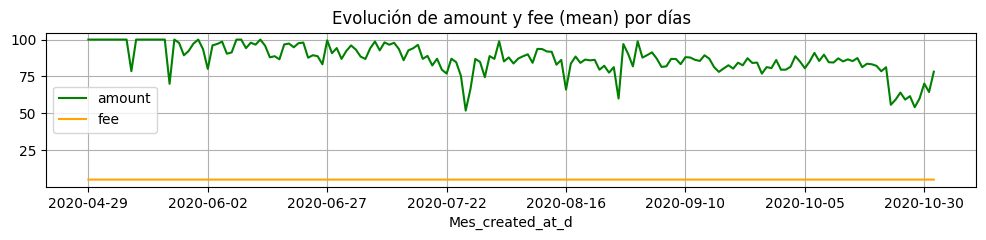

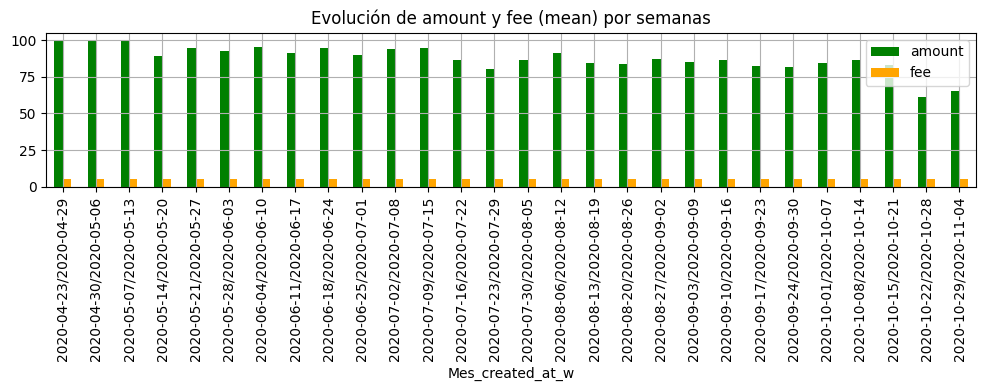

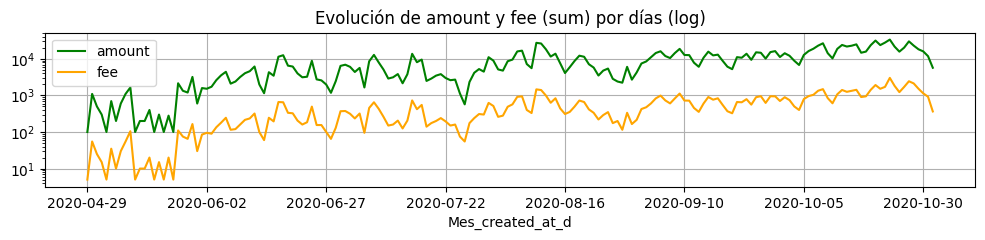

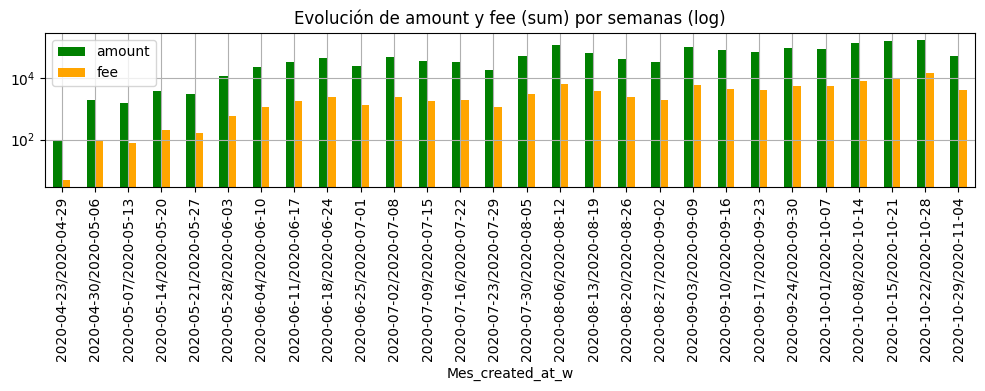

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear columnas de periodos temporales
merged_data['Mes_created_at_d'] = merged_data['created_at_x'].dt.to_period('D').astype(str)
merged_data['Mes_created_at_w'] = merged_data['created_at_x'].dt.to_period('W-WED').astype(str)
merged_data['Mes_created_at_m'] = merged_data['created_at_x'].dt.to_period('M').astype(str)

# Gráfico de medias por día
fig, ax = plt.subplots(figsize=(12,2))
plt.title('Evolución de amount y fee (mean) por días')
ratio_bag = merged_data.groupby('Mes_created_at_d')[['amount', 'total_amount']].mean()
ratio_bag.columns = ['amount', 'fee']  # Renombrar para visualización
ratio_bag.plot(kind='line', color=['green', 'orange'], ax=ax)
plt.grid()
plt.show()

# Gráfico de medias por semana
fig, ax = plt.subplots(figsize=(12,2))
plt.title('Evolución de amount y fee (mean) por semanas')
ratio_bag = merged_data.groupby('Mes_created_at_w')[['amount', 'total_amount']].mean()
ratio_bag.columns = ['amount', 'fee']
ratio_bag.plot(kind='bar', color=['green', 'orange'], ax=ax)
plt.grid()
plt.show()

# Gráfico de sumas por día (log)
fig, ax = plt.subplots(figsize=(12,2))
plt.title('Evolución de amount y fee (sum) por días (log)')
ratio_bag = merged_data.groupby('Mes_created_at_d')[['amount', 'total_amount']].sum()
ratio_bag.columns = ['amount', 'fee']
ratio_bag.plot(kind='line', color=['green', 'orange'], ax=ax)
plt.yscale('log')
plt.grid()
plt.show()




Un gráfico de sumas por semana (log) es un gráfico que:

Agrupa los datos por semanas.
Suma los valores de cada semana (en este caso, amount y fee).
Usa una escala logarítmica en el eje Y.

¿Para qué sirve?
* Mostrar la evolución de las sumas semanales de amount y fee (total_amount) a lo largo del tiempo.
* Permite detectar:
Semanas con picos o caídas inusuales.
Tendencias generales en las solicitudes de adelanto y los fees cobrados.
* Útil para comparar semanas con valores muy grandes y muy pequeños de forma clara.

**¿Por qué usar escala logarítmica?**

* La escala lineal muestra las diferencias tal como son, pero si hay valores muy grandes y muy pequeños, los pequeños apenas se ven.
* La escala logarítmica transforma los valores de esta forma:
10 → 1
100 → 2
1000 → 3
* Hace que las diferencias sean más visibles:
Si una semana tuvo 1000 € en fees y otra solo 10 €, en una escala lineal, la segunda apenas se nota.
Con log, ambas se ven con claridad, lo que ayuda a detectar semanas que de otro modo pasarían desapercibidas.

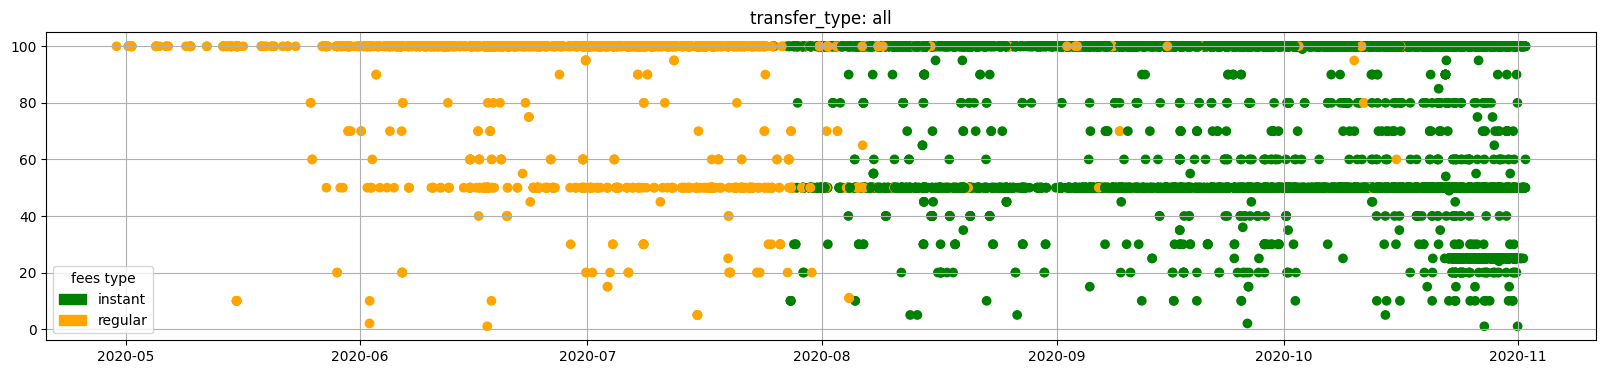

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

classification_colors = {'instant': 'green', 'regular': 'orange'}

# Gráfico: Todas las transferencias
fig, ax = plt.subplots(figsize=(20,4))
x_values = merged_data['created_at_x']
y_values = merged_data['amount']
c_values = list(merged_data['transfer_type'].map(classification_colors))
plt.scatter(x=x_values, y=y_values, c=c_values, alpha=1.0)
plt.title('transfer_type: all')
legend_patches = [mpatches.Patch(color=color, label=type) for type, color in classification_colors.items()]
plt.legend(handles=legend_patches, loc='best', title='fees type')
plt.grid()
plt.show()



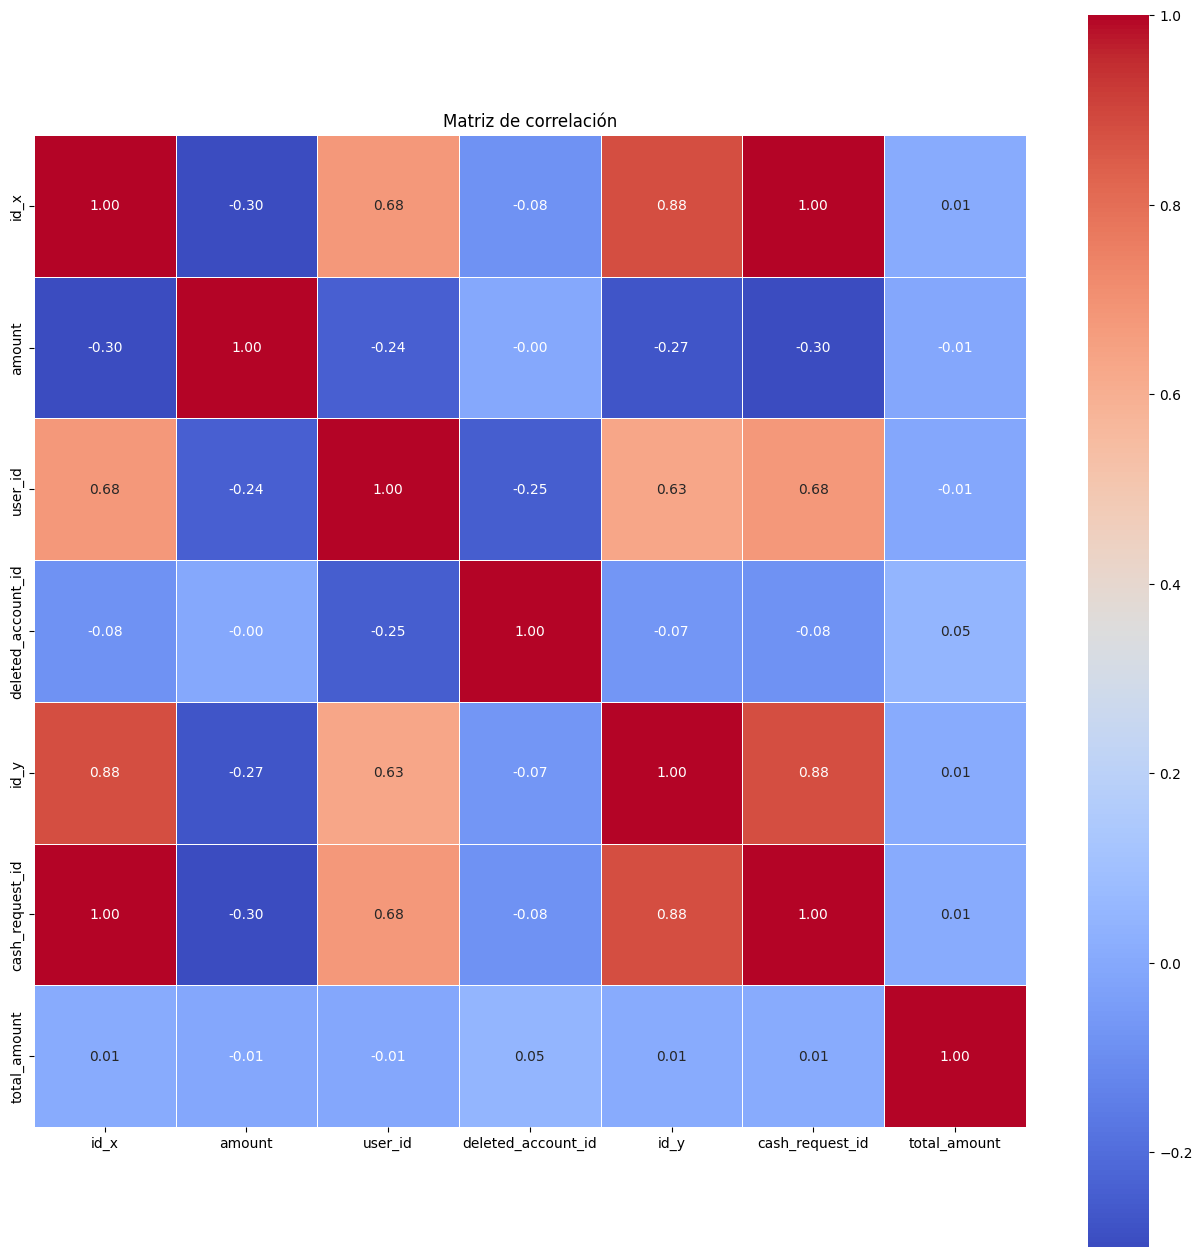

Variables altamente correlacionadas con otras:


['id_x', 'id_y', 'cash_request_id']

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Asegurar que las fechas sean datetime y convertirlas a formato numérico
for date in merged_data.select_dtypes(include=['datetime64']).columns:
    merged_data[date] = pd.to_datetime(merged_data[date], errors='coerce').dt.strftime('%Y%m%d').astype(float)

# Seleccionar solo columnas numéricas
df_corr = merged_data.select_dtypes(include=['number'])

# Reemplazar valores no válidos
df_corr.replace([np.inf, -np.inf], np.nan, inplace=True)
df_corr = df_corr.fillna(0)

# Calcular matriz de correlación
matriz_corr = df_corr.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(16, 16))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()

# Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.8
to_drop = [column for column in matriz_corr.columns if any((matriz_corr[column].abs() > threshold) & (matriz_corr.index != column))]

print("Variables altamente correlacionadas con otras:")
display(to_drop)


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,id_x,amount,status_x,created_at_x,updated_at_x,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,Mes_created_at_d,id_y,cash_request_id,type,status_y,category,total_amount,reason,created_at_y,updated_at_y,paid_at,from_date,to_date,charge_moment,Mes_created_at_w,Mes_created_at_m
0,23534,25.0,money_back,2020-10-23 15:20:26.163927+00:00,2020-12-18 13:08:29.099365+00,21465.0,NaN,NaN,2020-11-10 23:51:00+00:00,2020-10-26 15:21:26.878525+00:00,2020-11-06 07:16:21.845479+00,instant,2020-10-23 15:21:26.878525+00:00,NaN,NaN,NaN,2020-10-23,16460,23534.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23534,2020-10-23 15:21:35.895711+00:00,2020-10-23 15:21:35.89574+00,2020-11-06 07:16:22.014422+00,NaN,NaN,after,2020-10-22/2020-10-28,2020-10
1,2203,100.0,money_back,2020-05-27 02:26:27.615190+00:00,2020-06-09 11:25:51.72636+00,2109.0,2020-05-27 10:02:13.094467+00,NaN,2020-07-15 02:26:27+00:00,2020-05-29 00:00:00,2020-07-15 22:00:00+00,regular,NaT,NaN,NaN,NaN,2020-05-27,100,2203.0,postpone,accepted,NaN,5.0,Postpone Cash Request 2203,2020-06-09 11:25:52.449808+00:00,2020-10-13 14:25:00.867548+00,NaN,2020-06-15 02:26:27+00,2020-07-15 02:26:27+00,before,2020-05-21/2020-05-27,2020-05
2,6098,100.0,active,2020-07-01 09:30:03.145410+00:00,2020-08-11 22:27:58.240406+00,23328.0,2020-07-01 16:44:53.070844+00,NaN,2020-08-03 22:00:00+00:00,2020-07-03 00:00:00,NaN,regular,NaT,pending,2020-08-11 22:27:55.367849+00,2020-08-11 22:27:58.255621+00,2020-07-01,3733,6098.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 6098,2020-08-13 10:58:39.634220+00:00,2020-10-13 14:25:16.660127+00,NaN,2020-08-03 22:00:00+00,2020-09-03 10:58:32.274+00,after,2020-06-25/2020-07-01,2020-07
3,6098,100.0,active,2020-07-01 09:30:03.145410+00:00,2020-08-11 22:27:58.240406+00,23328.0,2020-07-01 16:44:53.070844+00,NaN,2020-08-03 22:00:00+00:00,2020-07-03 00:00:00,NaN,regular,NaT,pending,2020-08-11 22:27:55.367849+00,2020-08-11 22:27:58.255621+00,2020-07-01,3734,6098.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 6098,2020-08-13 10:58:52.603153+00:00,2020-10-13 14:25:16.661371+00,NaN,2020-08-03 22:00:00+00,2020-09-03 10:58:32.274+00,after,2020-06-25/2020-07-01,2020-07
4,6098,100.0,active,2020-07-01 09:30:03.145410+00:00,2020-08-11 22:27:58.240406+00,23328.0,2020-07-01 16:44:53.070844+00,NaN,2020-08-03 22:00:00+00:00,2020-07-03 00:00:00,NaN,regular,NaT,pending,2020-08-11 22:27:55.367849+00,2020-08-11 22:27:58.255621+00,2020-07-01,3735,6098.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 6098,2020-08-13 11:00:39.879521+00:00,2020-10-13 14:25:16.662449+00,NaN,2020-08-03 22:00:00+00,2020-09-01 11:00:34.027+00,after,2020-06-25/2020-07-01,2020-07


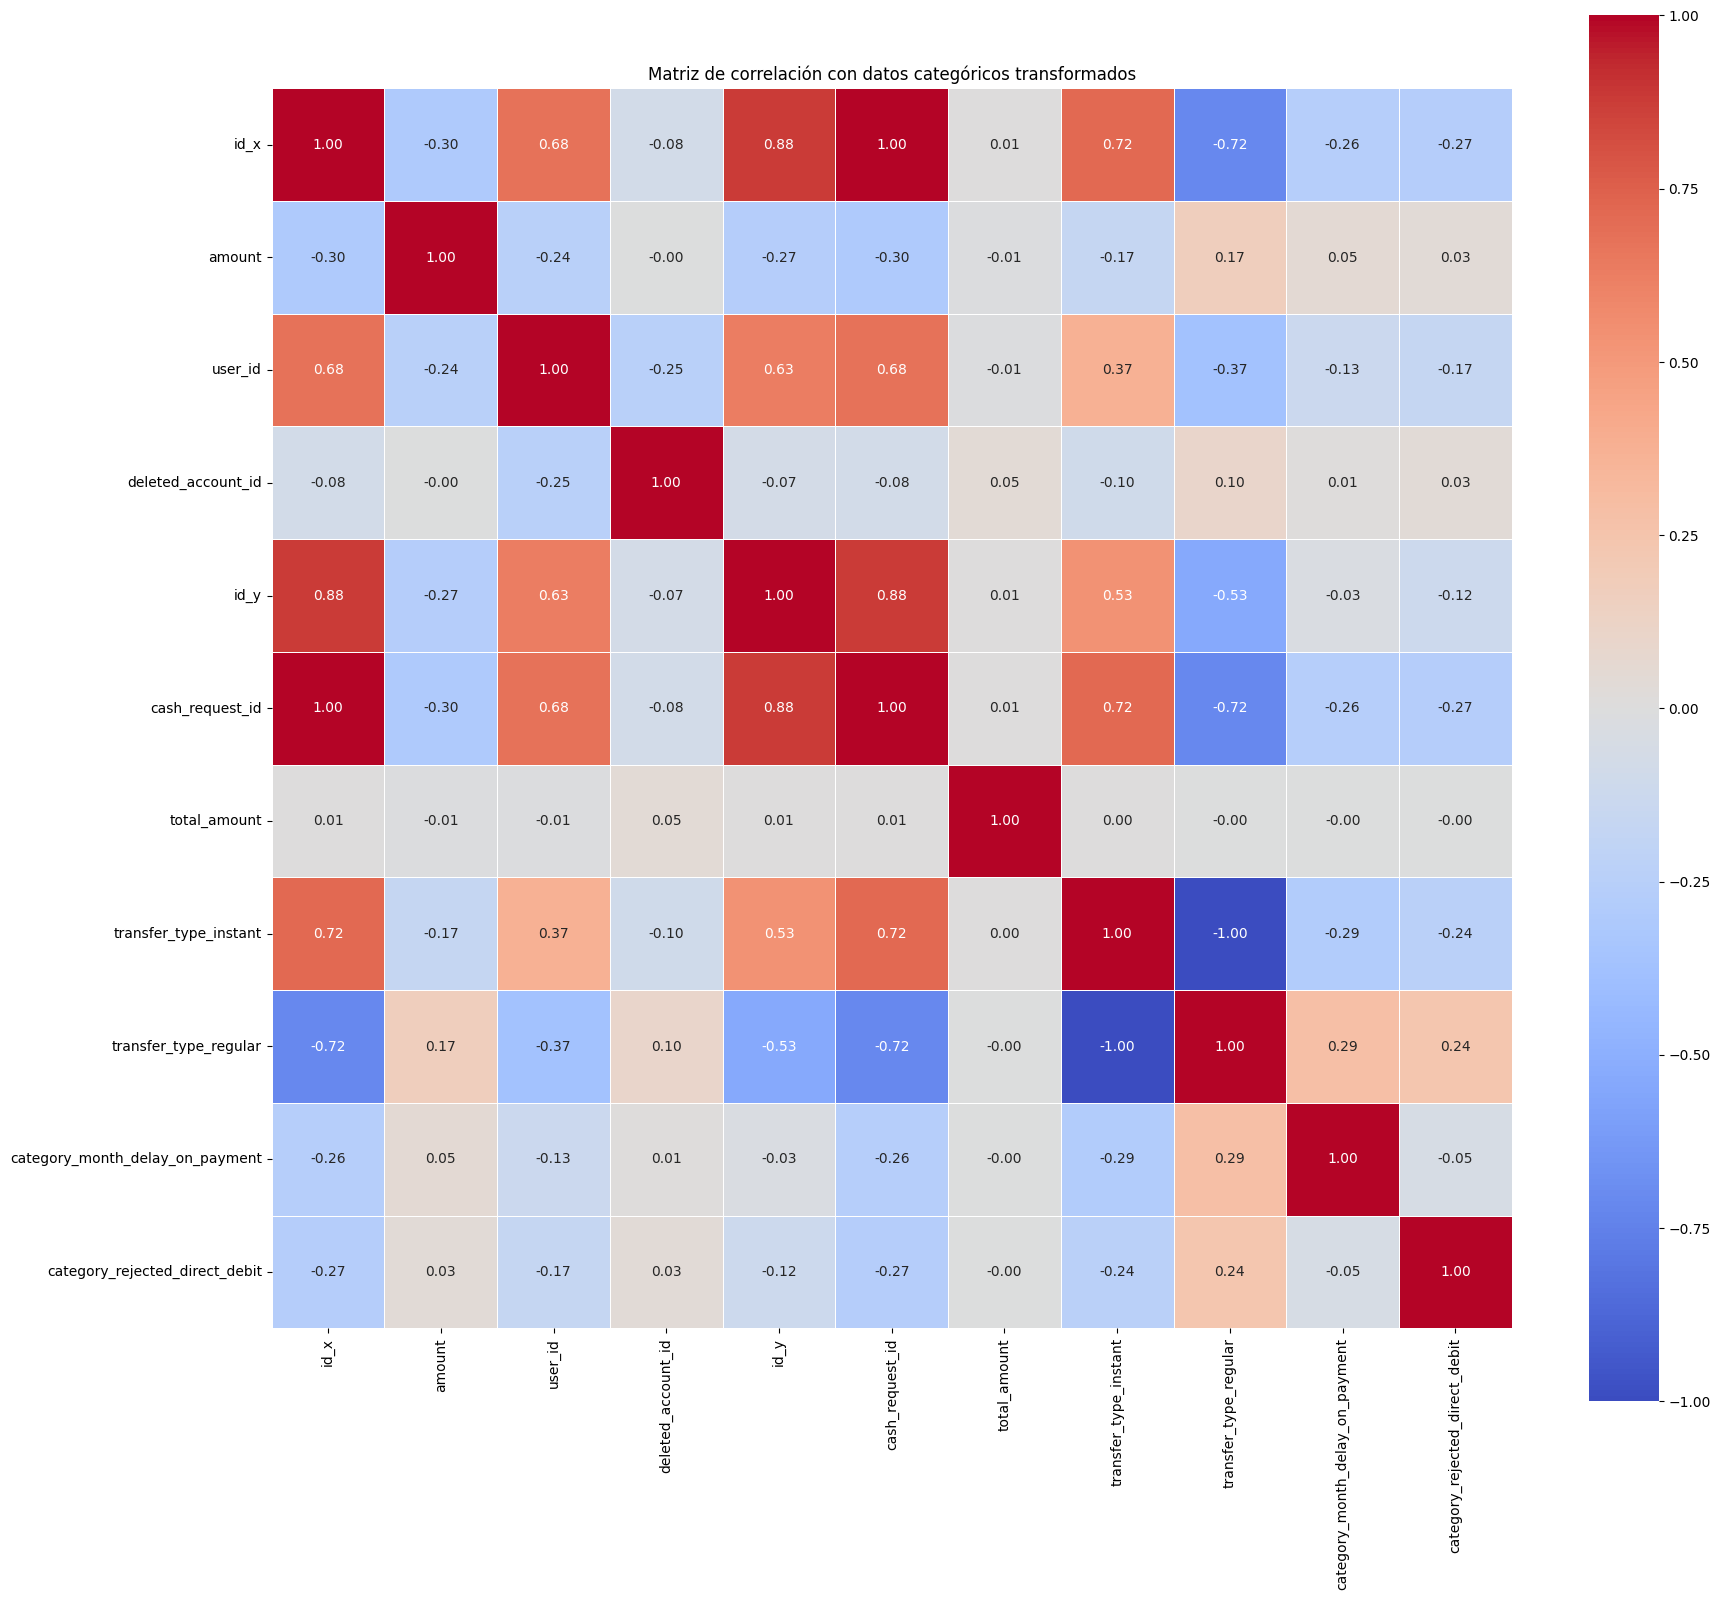

Variables altamente correlacionadas con otras:


['id_x',
 'id_y',
 'cash_request_id',
 'transfer_type_instant',
 'transfer_type_regular']

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convertir fechas a formato numérico
d_list = list(merged_data.select_dtypes(include=['datetime64']).columns)
for date in d_list:
    merged_data[date] = pd.to_datetime(merged_data[date], errors='coerce').dt.strftime('%Y%m%d').astype(float)
display(merged_data.head())
# Aplicar One-Hot Encoding a transfer_type y category
merged_data = pd.get_dummies(merged_data, columns=['transfer_type', 'category'], prefix=['transfer_type', 'category'])

# Seleccionar columnas numéricas y booleanas
df_corr = merged_data.select_dtypes(include=['number'])
df_bool = merged_data.select_dtypes(include=['bool'])
df_corr = pd.concat([df_corr, df_bool], axis=1)

# Reemplazar valores no válidos
df_corr.replace([np.inf, -np.inf], np.nan, inplace=True)
df_corr = df_corr.fillna(0)

# Calcular y visualizar la matriz de correlación
matriz_corr = df_corr.corr()
plt.figure(figsize=(20, 18))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Matriz de correlación con datos categóricos transformados')
plt.show()

# Identificar columnas con alta correlación
threshold = 0.8
to_drop = [column for column in matriz_corr.columns if any((matriz_corr[column].abs() > threshold) & (matriz_corr.index != column))]

print("Variables altamente correlacionadas con otras:")
display(to_drop)







Rangos de fechas: mínima: 2020-04-29 19:16:43.071488+00:00 máxima: 2020-11-01 23:42:30.847066+00:00


<ipython-input-15-16122814e5c5>:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  merged_data['Mes_created_at'] = merged_data['created_at_x'].dt.to_period('D')


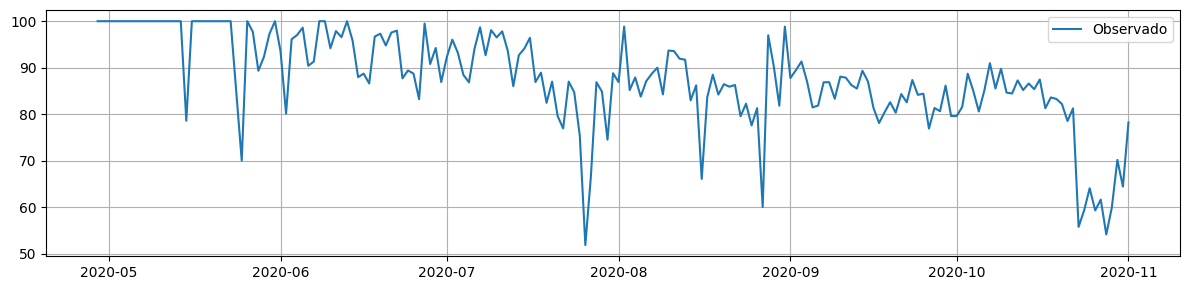

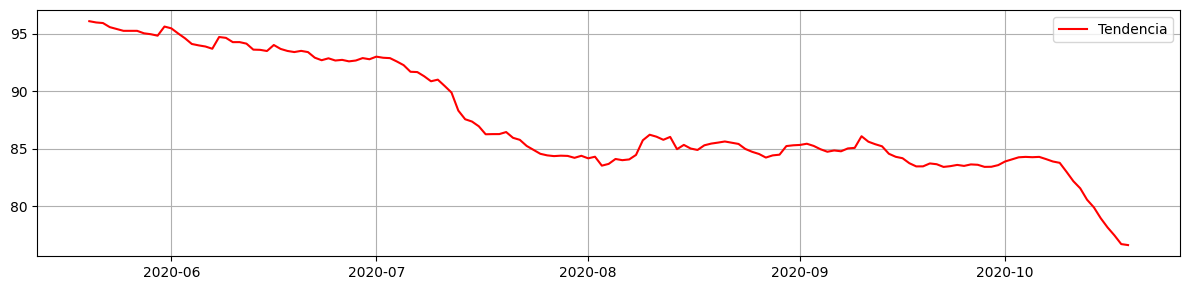

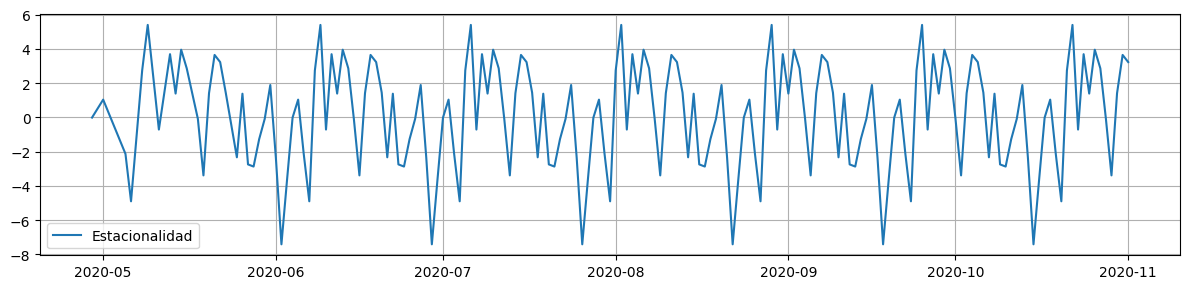

In [15]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

#Periodo de ~28 días
merged_data['Mes_created_at'] = merged_data['created_at_x'].dt.to_period('D')
print(f"Rangos de fechas: mínima: {merged_data.created_at_x.min()} máxima: {merged_data.created_at_x.max()}")
df_grouped = merged_data.groupby('Mes_created_at')['amount'].mean()
df_grouped.index = df_grouped.index.to_timestamp()
df_decomp = seasonal_decompose(df_grouped, model='additive', period=(int)(165/6))

plt.figure(figsize=(12, 3))
plt.plot(df_decomp.observed, label='Observado')
plt.legend(loc='best');plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 3))
plt.plot(df_decomp.seasonal, label='Estacionalidad')
plt.legend(loc='best');plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-16-e02eab9ce1ac>:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  moderated['moderated_at_m'] = moderated['moderated_at'].dt.to_period('M')
<ipython-input-16-e02eab9ce1ac>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moderated['moderated_at_m'] = moderated['moderated_at'].dt.to_period('M')


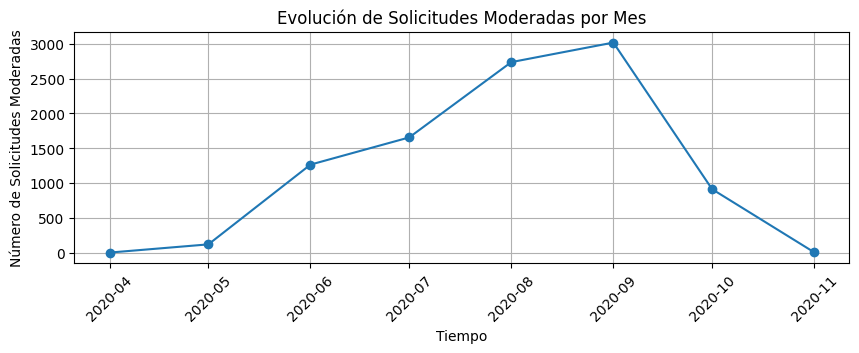

<ipython-input-16-e02eab9ce1ac>:28: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  moderated['moderated_at_m'] = moderated['moderated_at'].dt.to_period('D')
<ipython-input-16-e02eab9ce1ac>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moderated['moderated_at_m'] = moderated['moderated_at'].dt.to_period('D')
<ipython-input-16-e02eab9ce1ac>:29: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  created_at['created_at_m'] = created_at['created_at_x'].dt.to_period('D')


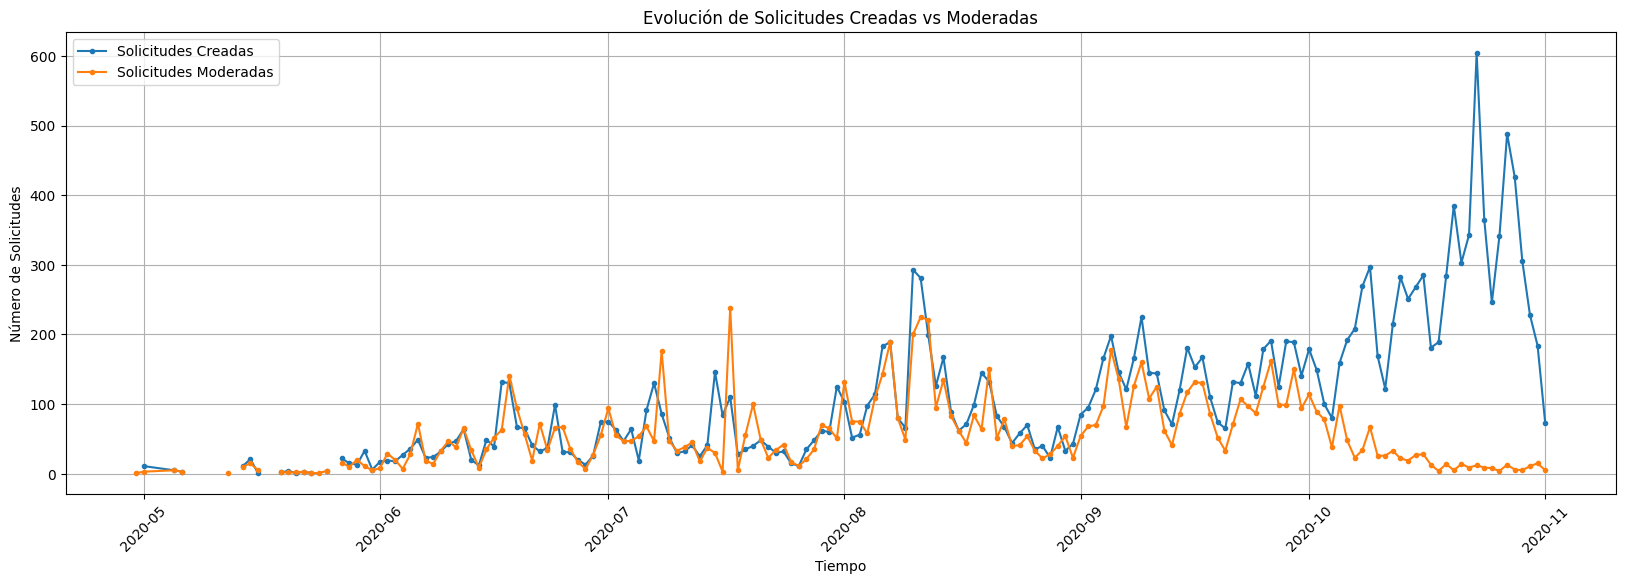

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Ordenar y filtrar datos
merged_data = merged_data.copy().sort_values(['created_at_x', 'moderated_at'])

# Asegurar que las fechas sean datetime
merged_data['moderated_at'] = pd.to_datetime(merged_data['moderated_at'], errors='coerce')
merged_data['created_at_x'] = pd.to_datetime(merged_data['created_at_x'], errors='coerce')

moderated = merged_data[merged_data['moderated_at'].notnull()]
created_at = merged_data[merged_data['created_at_x'].notnull()]

# Agrupación por mes
moderated['moderated_at_m'] = moderated['moderated_at'].dt.to_period('M')
moderation_time_series = moderated.groupby('moderated_at_m').size().reset_index(name='count')
moderation_time_series['moderated_at_m'] = moderation_time_series['moderated_at_m'].dt.to_timestamp()
plt.figure(figsize=(10, 3))
plt.plot(moderation_time_series['moderated_at_m'], moderation_time_series['count'], marker='o')
plt.title('Evolución de Solicitudes Moderadas por Mes')
plt.xlabel('Tiempo')
plt.ylabel('Número de Solicitudes Moderadas')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Agrupación por día
moderated['moderated_at_m'] = moderated['moderated_at'].dt.to_period('D')
created_at['created_at_m'] = created_at['created_at_x'].dt.to_period('D')
moderation_time_series = moderated.groupby('moderated_at_m').size().reset_index(name='count')
creation_time_series = created_at.groupby('created_at_m').size().reset_index(name='count')

# Unir y graficar
merged_df = pd.merge(moderation_time_series, creation_time_series, left_on='moderated_at_m', right_on='created_at_m', how='outer')
merged_df['moderated_at_m'] = merged_df['moderated_at_m'].dt.to_timestamp()
plt.figure(figsize=(20, 6))
plt.plot(merged_df['moderated_at_m'], merged_df['count_y'], marker='.', label='Solicitudes Creadas')
plt.plot(merged_df['moderated_at_m'], merged_df['count_x'], marker='.', label='Solicitudes Moderadas')
plt.title('Evolución de Solicitudes Creadas vs Moderadas')
plt.xlabel('Tiempo')
plt.ylabel('Número de Solicitudes')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()


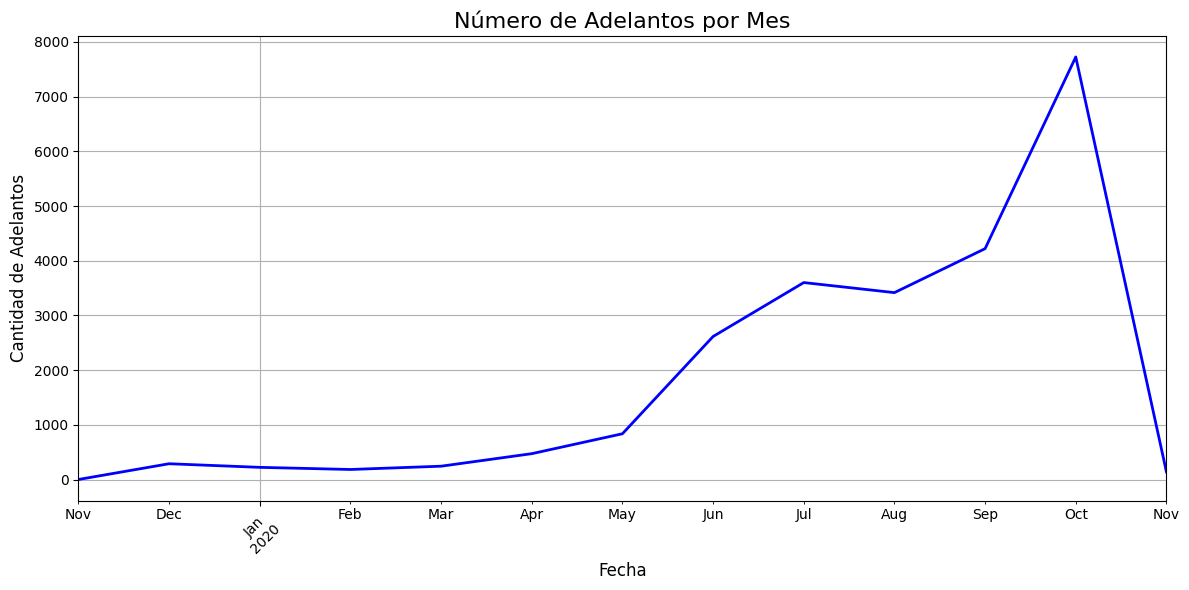

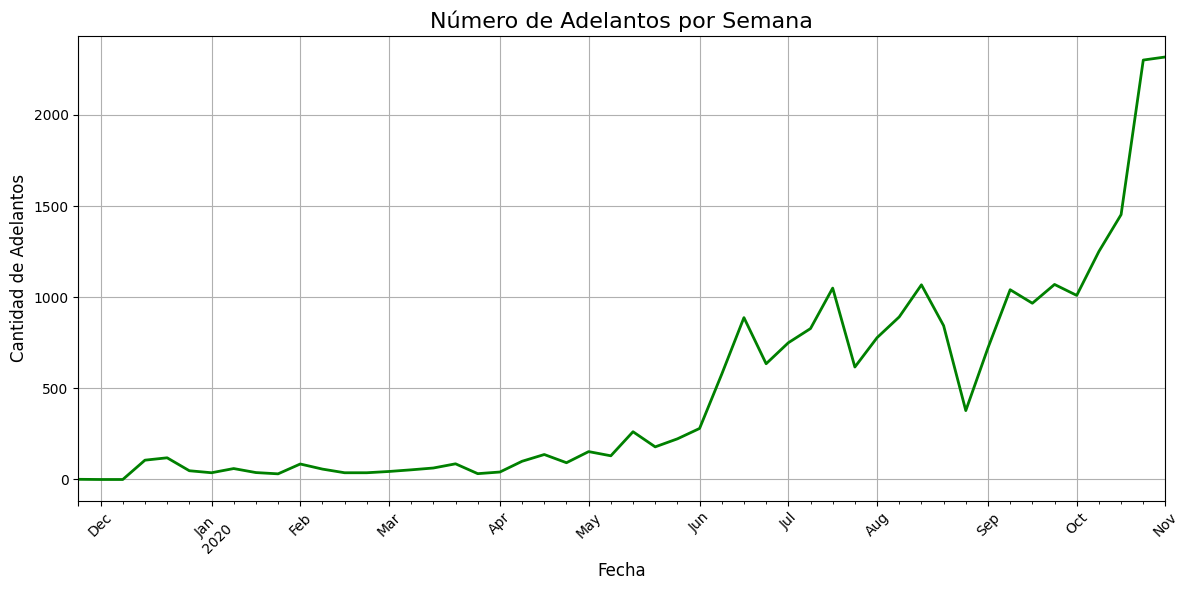

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegurarnos de que `created_at` esté en formato datetime
cash_request_data['created_at'] = pd.to_datetime(cash_request_data['created_at'], errors='coerce')

# Resample por mes para contar la cantidad de adelantos
df_monthly = cash_request_data.resample('ME', on='created_at').size()

# Graficar la cantidad de adelantos por mes
plt.figure(figsize=(12, 6))
df_monthly.plot(kind='line', color='blue', linewidth=2)
plt.title('Número de Adelantos por Mes', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Cantidad de Adelantos', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Resample por semana para contar la cantidad de adelantos
df_weekly = cash_request_data.resample('W', on='created_at').size()

# Graficar la cantidad de adelantos por semana
plt.figure(figsize=(12, 6))
df_weekly.plot(kind='line', color='green', linewidth=2)
plt.title('Número de Adelantos por Semana', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Cantidad de Adelantos', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-20-3abf7ac5ced3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['week_of_year'] = df_valid['created_at'].dt.isocalendar().week


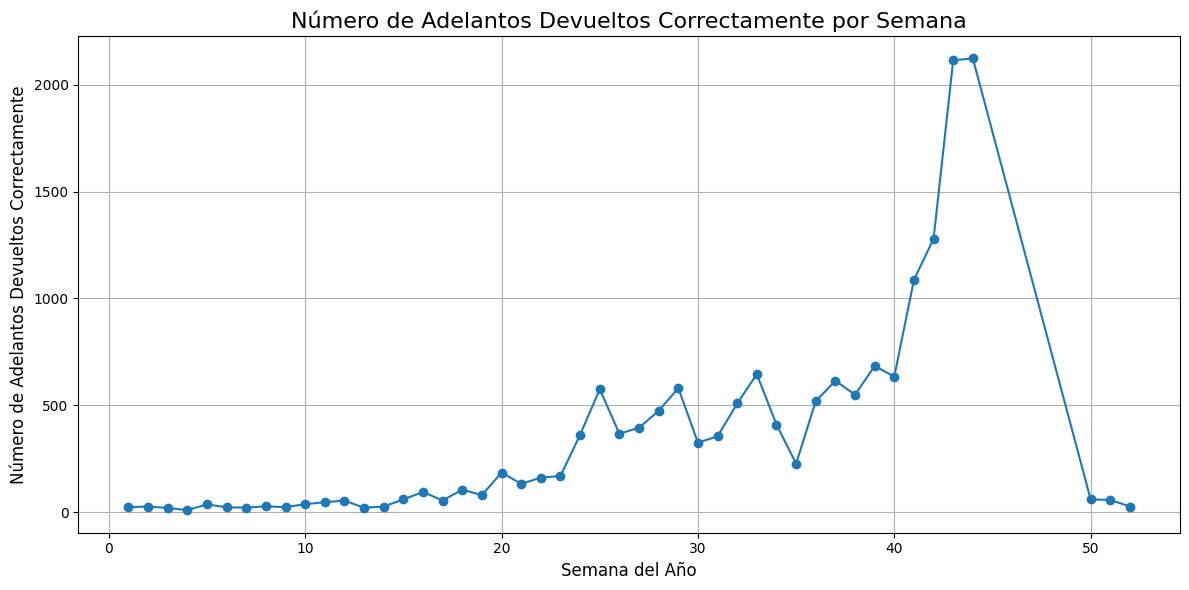

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegúrate de que `created_at` esté en formato datetime
cash_request_data['created_at'] = pd.to_datetime(cash_request_data['created_at'], errors='coerce')

# Filtrar los préstamos devueltos correctamente según los estados reales de tu dataset
valid_principal_returned = ['money_back', 'direct_debit_sent']  # Estados reales para préstamos devueltos

df_valid = cash_request_data[cash_request_data['status'].isin(valid_principal_returned)]

# Extraer el número de semana del año
df_valid['week_of_year'] = df_valid['created_at'].dt.isocalendar().week

# Contar los préstamos por cada semana
df_weekly_loans = df_valid.groupby('week_of_year').size().reset_index(name='loan_count')

# Crear el gráfico de líneas
plt.figure(figsize=(12, 6))
plt.plot(df_weekly_loans['week_of_year'], df_weekly_loans['loan_count'], marker='o')

# Ajustes del gráfico
plt.title('Número de Adelantos Devueltos Correctamente por Semana', fontsize=16)
plt.xlabel('Semana del Año', fontsize=12)
plt.ylabel('Número de Adelantos Devueltos Correctamente', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


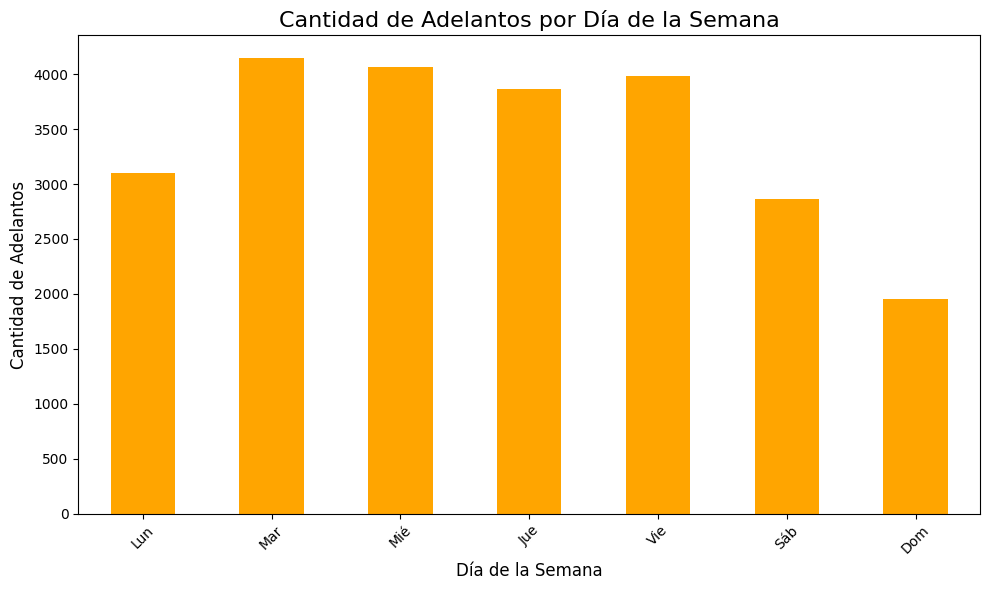

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegurarnos de que `created_at` esté en formato datetime
cash_request_data['created_at'] = pd.to_datetime(cash_request_data['created_at'], errors='coerce')

# Agregar la columna `day_of_week` (día de la semana)
cash_request_data['day_of_week'] = cash_request_data['created_at'].dt.dayofweek

# Contar los adelantos por día de la semana
df_day_of_week = cash_request_data.groupby('day_of_week').size()

# Graficar la cantidad de adelantos por día de la semana
plt.figure(figsize=(10, 6))
df_day_of_week.plot(kind='bar', color='orange')
plt.title('Cantidad de Adelantos por Día de la Semana', fontsize=16)
plt.xlabel('Día de la Semana', fontsize=12)
plt.ylabel('Cantidad de Adelantos', fontsize=12)
plt.xticks(ticks=range(7), labels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'], rotation=45)
plt.tight_layout()
plt.show()


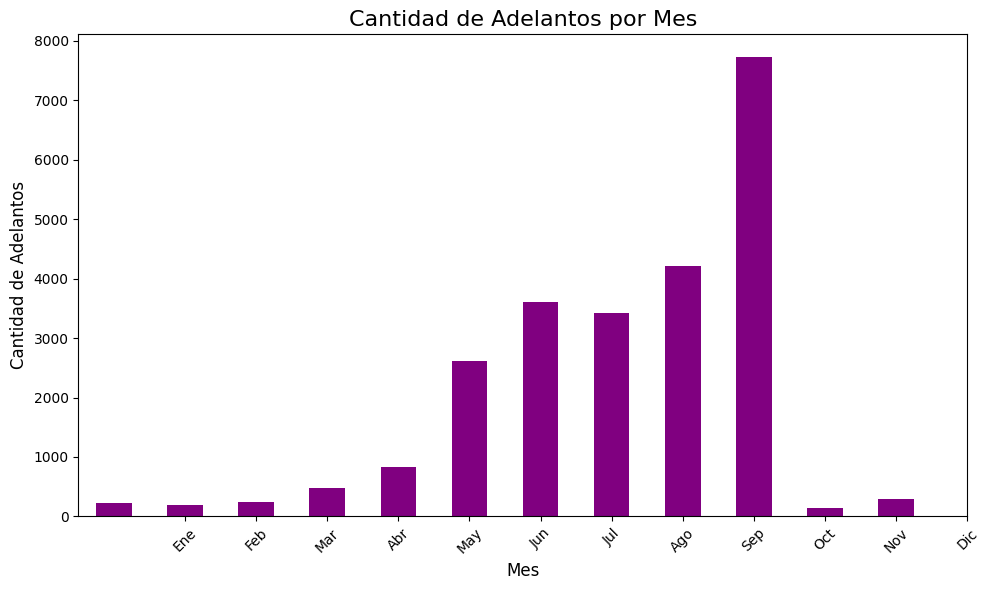

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegurarnos de que `created_at` esté en formato datetime
cash_request_data['created_at'] = pd.to_datetime(cash_request_data['created_at'], errors='coerce')

# Agregar la columna `month` (mes del año)
cash_request_data['month'] = cash_request_data['created_at'].dt.month

# Contar los adelantos por mes
df_month = cash_request_data.groupby('month').size()

# Graficar la cantidad de adelantos por mes
plt.figure(figsize=(10, 6))
df_month.plot(kind='bar', color='purple')
plt.title('Cantidad de Adelantos por Mes', fontsize=16)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Cantidad de Adelantos', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=45)
plt.tight_layout()
plt.show()


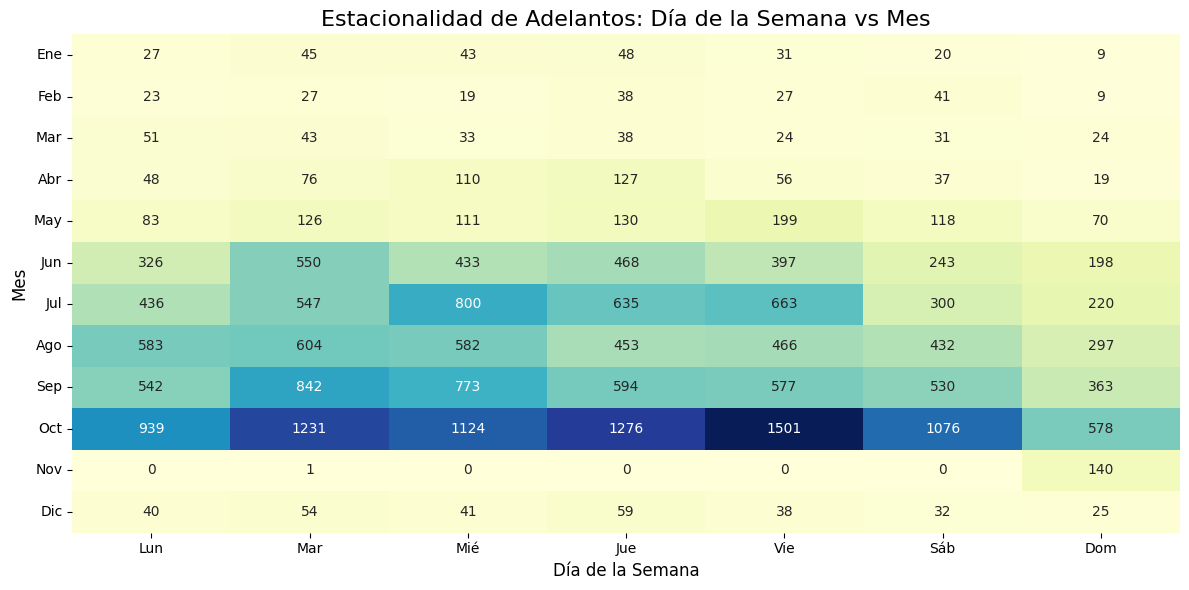

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurarnos de que `created_at` esté en formato datetime
cash_request_data['created_at'] = pd.to_datetime(cash_request_data['created_at'], errors='coerce')

# Crear columnas de mes y día de la semana
cash_request_data['month'] = cash_request_data['created_at'].dt.month
cash_request_data['day_of_week'] = cash_request_data['created_at'].dt.dayofweek

# Contar los adelantos por mes y día de la semana
df_heatmap = cash_request_data.groupby(['month', 'day_of_week']).size().unstack(fill_value=0)

# Graficar un heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_heatmap, cmap='YlGnBu', annot=True, fmt='d', cbar=False)
plt.title('Estacionalidad de Adelantos: Día de la Semana vs Mes', fontsize=16)
plt.xlabel('Día de la Semana', fontsize=12)
plt.ylabel('Mes', fontsize=12)
plt.xticks(ticks=np.arange(7) + 0.5, labels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])
plt.yticks(ticks=np.arange(12) + 0.5, labels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=0)
plt.tight_layout()
plt.show()


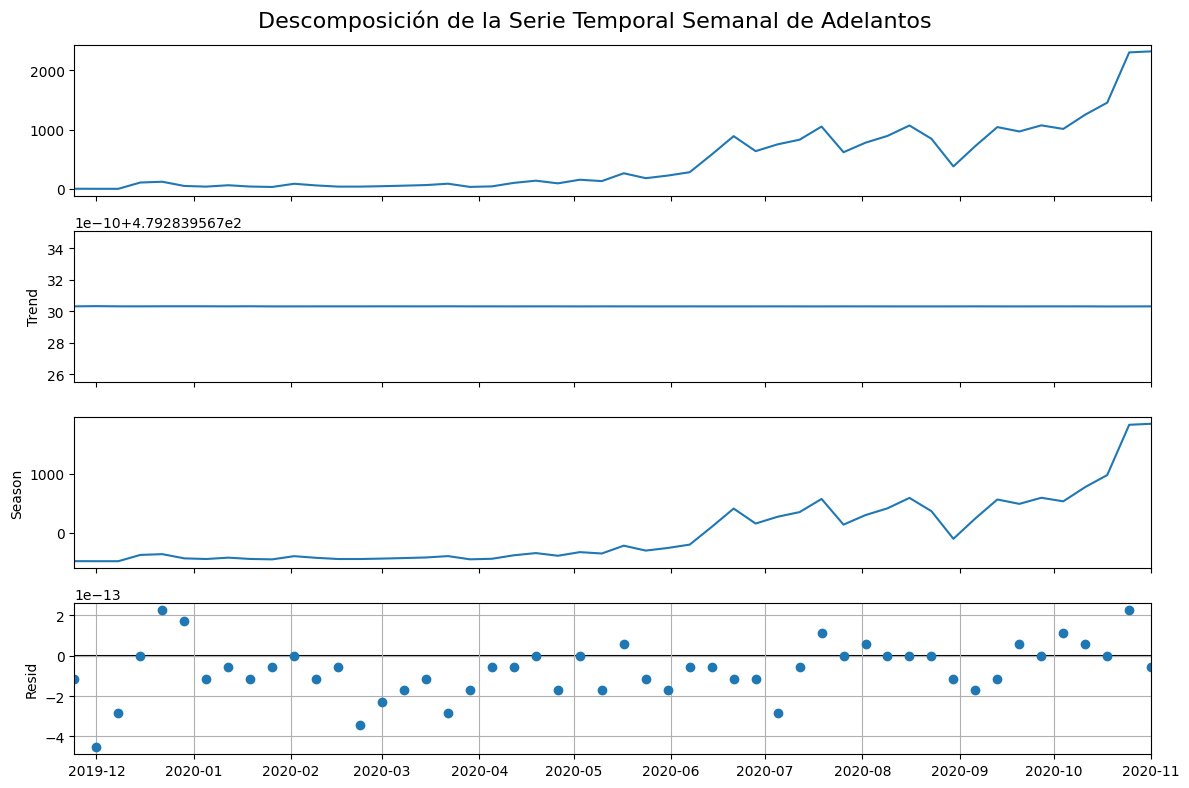

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Asegurarnos de que `created_at` esté en formato datetime
cash_request_data['created_at'] = pd.to_datetime(cash_request_data['created_at'], errors='coerce')

# Agrupar los datos por semana, contando la cantidad de adelantos por semana
df_weekly = cash_request_data.resample('W', on='created_at').size()

# Aplicar la descomposición STL
stl = STL(df_weekly, seasonal=13)  # 13 para capturar la estacionalidad semanal
result = stl.fit()

# Graficar la descomposición
fig = result.plot()
fig.set_size_inches((12, 8))
plt.grid()
plt.suptitle('Descomposición de la Serie Temporal Semanal de Adelantos', fontsize=16)
plt.tight_layout()
plt.show()


**La descomposición temporal STL te ayuda a separar la serie de adelantos en tres componentes:**

1. Tendencia: Muestra la dirección general (si los adelantos están aumentando o disminuyendo con el tiempo).
1. Estacionalidad: Detecta patrones recurrentes semanales.
1. Residuo: Captura las irregularidades o anomalías que no siguen la tendencia ni la estacionalidad.
   * Valores cercanos a cero: Indican que los datos observados están bien explicados por la tendencia y la estacionalidad.
   * Valores muy alejados de cero: Pueden ser eventos atípicos (outliers), errores de registro, o situaciones inesperadas (por ejemplo, un aumento brusco de adelantos debido a una promoción, o una caída por problemas técnicos).)

Esto es útil para identificar picos estacionales, evaluar el crecimiento o disminución de la demanda de adelantos, y detectar anomalías que podrían necesitar investigación.

AttributeError: module 'matplotlib.pyplot' has no attribute 'xl'

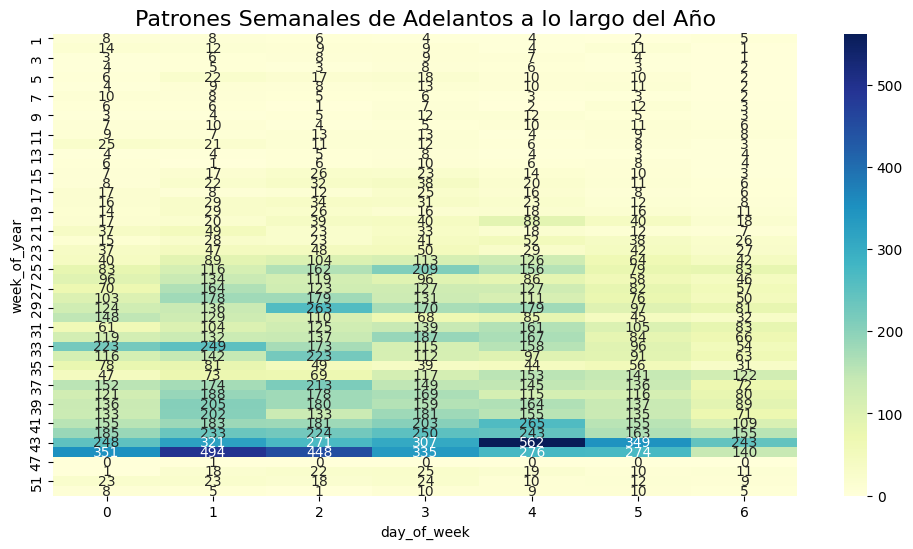

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Asegurarnos de que `created_at` esté en formato datetime
cash_request_data['created_at'] = pd.to_datetime(cash_request_data['created_at'], errors='coerce')

# Extraer la semana del año
cash_request_data['week_of_year'] = cash_request_data['created_at'].dt.isocalendar().week

# Extraer el día de la semana
cash_request_data['day_of_week'] = cash_request_data['created_at'].dt.dayofweek

# Contar los adelantos por semana del año y día de la semana
df_heatmap = cash_request_data.groupby(['week_of_year', 'day_of_week']).size().unstack(fill_value=0)

# Crear un gráfico de calor para visualizar los patrones semanales
plt.figure(figsize=(12, 6))
sns.heatmap(df_heatmap, cmap='YlGnBu', annot=True, fmt='d', cbar=True)

plt.title('Patrones Semanales de Adelantos a lo largo del Año', fontsize=16)
plt.xl


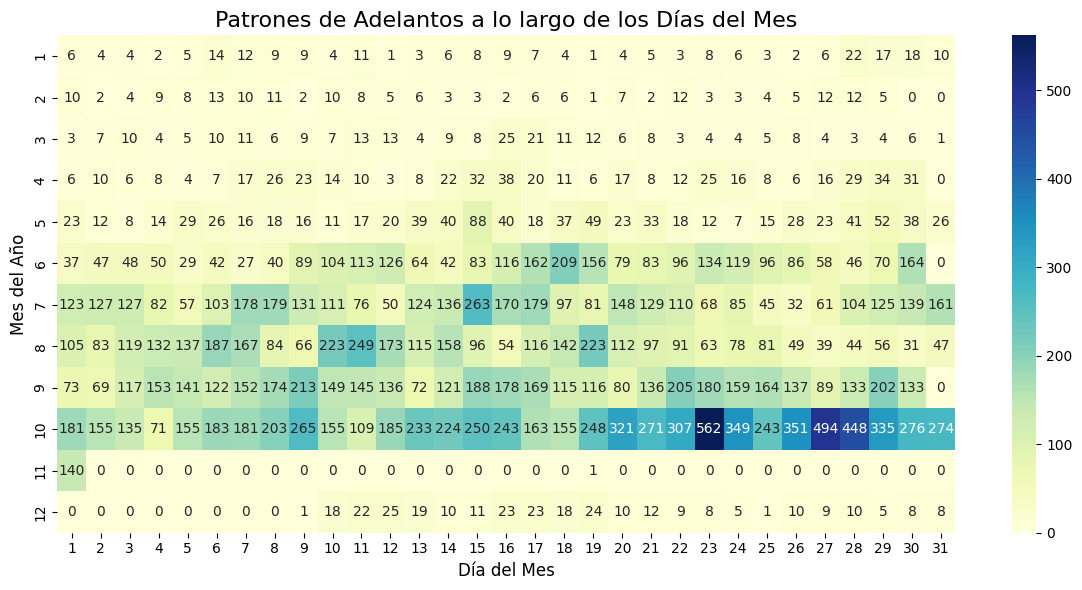

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Asegurarnos de que `created_at` esté en formato datetime
cash_request_data['created_at'] = pd.to_datetime(cash_request_data['created_at'], errors='coerce')

# Extraer el día del mes
cash_request_data['day_of_month'] = cash_request_data['created_at'].dt.day

# Extraer el mes del año
cash_request_data['month_of_year'] = cash_request_data['created_at'].dt.month

# Contar los adelantos por cada combinación de mes y día del mes
df_heatmap_month = cash_request_data.groupby(['month_of_year', 'day_of_month']).size().unstack(fill_value=0)

# Crear un gráfico de calor para visualizar los patrones por día del mes
plt.figure(figsize=(12, 6))
sns.heatmap(df_heatmap_month, cmap='YlGnBu', annot=True, fmt='d', cbar=True)

plt.title('Patrones de Adelantos a lo largo de los Días del Mes', fontsize=16)
plt.xlabel('Día del Mes', fontsize=12)
plt.ylabel('Mes del Año', fontsize=12)
plt.xticks(ticks=np.arange(31) + 0.5, labels=np.arange(1, 32))
plt.tight_layout()
plt.show()


<ipython-input-17-c79d9bbc374c>:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  merged_data['created_at_d'] = merged_data['created_at_x'].dt.to_period('D').astype(str)
<ipython-input-17-c79d9bbc374c>:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  merged_data['created_at_w'] = merged_data['created_at_x'].dt.to_period('W-WED').astype(str)
<ipython-input-17-c79d9bbc374c>:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  merged_data['created_at_m'] = merged_data['created_at_x'].dt.to_period('M').astype(str)


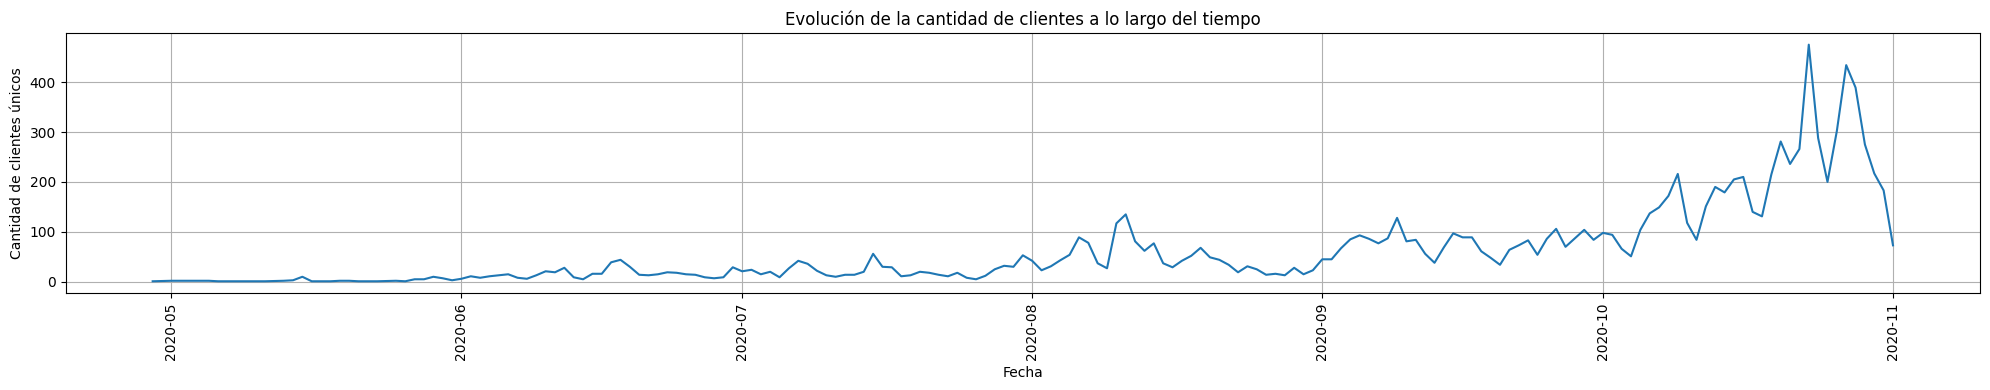

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Ordenar y crear periodos temporales
merged_data = merged_data.sort_values(['created_at_x', 'created_at_y'])
merged_data['created_at_d'] = merged_data['created_at_x'].dt.to_period('D').astype(str)
merged_data['created_at_w'] = merged_data['created_at_x'].dt.to_period('W-WED').astype(str)
merged_data['created_at_m'] = merged_data['created_at_x'].dt.to_period('M').astype(str)



# Gráfico de la cantidad de clientes a lo largo del tiempo
client_evolution = merged_data.groupby(merged_data['created_at_x'].dt.date)['user_id'].nunique()
plt.figure(figsize=(20, 4))
plt.plot(client_evolution.index, client_evolution.values)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de clientes únicos')
plt.title('Evolución de la cantidad de clientes a lo largo del tiempo')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid()
plt.show()


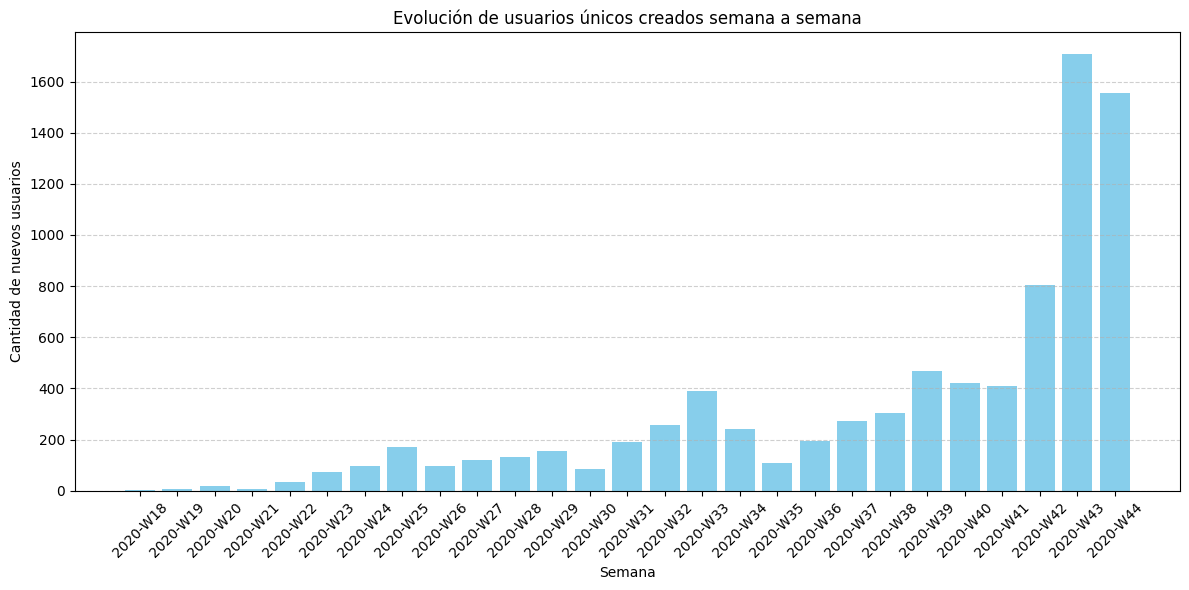

user_id
16391.0    37
15593.0    28
3045.0     25
17144.0    24
23823.0    23
           ..
67715.0     1
80851.0     1
49079.0     1
80623.0     1
96599.0     1
Name: count, Length: 8298, dtype: int64


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegurar que las fechas sean datetime
merged_data['created_at_x'] = pd.to_datetime(merged_data['created_at_x'], errors='coerce')

# Crear columna de la semana y año
merged_data['week'] = merged_data['created_at_x'].dt.isocalendar().week
merged_data['year'] = merged_data['created_at_x'].dt.year

# Filtrar usuarios únicos por semana
seen_users = set()
weekly_new_users = []

for week, group in merged_data.groupby(['year', 'week']):
    unique_users = group.loc[~group['user_id'].isin(seen_users), 'user_id'].unique()
    seen_users.update(unique_users)
    weekly_new_users.append({'year_week': f"{week[0]}-W{week[1]:02d}", 'new_users': len(unique_users)})

# Convertir a DataFrame
weekly_data = pd.DataFrame(weekly_new_users)

# Graficar la evolución de usuarios únicos creados semana a semana
plt.figure(figsize=(12, 6))
plt.bar(weekly_data['year_week'], weekly_data['new_users'], color='skyblue')
plt.xticks(rotation=45)
plt.title('Evolución de usuarios únicos creados semana a semana')
plt.xlabel('Semana')
plt.ylabel('Cantidad de nuevos usuarios')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Conteo de user_id
counts_user_id = merged_data['user_id'].value_counts()
print(counts_user_id)


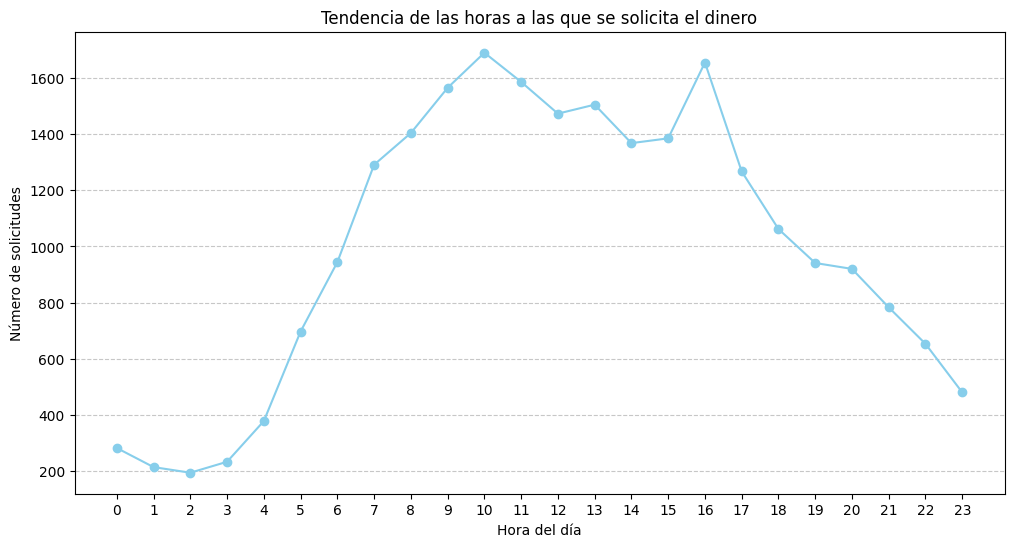

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegurar que las fechas sean datetime
cash_request_data['created_at'] = pd.to_datetime(cash_request_data['created_at'], errors='coerce')

# Extraer la hora de la solicitud
cash_request_data['hour'] = cash_request_data['created_at'].dt.hour

# Contar solicitudes por hora
hourly_requests = cash_request_data['hour'].value_counts().sort_index()

# Graficar la tendencia de solicitudes por hora
plt.figure(figsize=(12, 6))
plt.plot(hourly_requests.index, hourly_requests.values, marker='o', color='skyblue')
plt.title('Tendencia de las horas a las que se solicita el dinero')
plt.xlabel('Hora del día')
plt.ylabel('Número de solicitudes')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
